In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-18T19:28:57.815770+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn import preprocessing
from catboost import CatBoostRegressor, Pool

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

cb_version: 0.24.3
sklearn_version: 0.24.2


In [5]:
%watermark --iversions

matplotlib: 3.3.4
numpy     : 1.20.3
pandas    : 0.25.3
sklearn   : 0.24.2
seaborn   : 0.11.1



## Reproducibility block

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED = 309487

In [7]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [8]:
NTRY = 14
NAME = f'{NTRY}_cb_pca64_sber_lags_parse_bord_nose'

In [41]:
CTR_UKR = 6.096

VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Load data

In [9]:
df_train  = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'), index_col= 0)
x_train  = pd.read_csv(os.path.join(DIR_DATA, 'x_train.csv'), index_col= 0)
x_val    = pd.read_csv(os.path.join(DIR_DATA, 'x_val.csv'), index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index_col= 0)

with open(os.path.join(DIR_DATA, 'cat_columns.pkl'), 'rb') as pickle_file:
    cat_cols = pkl.load(pickle_file)
    
with open(os.path.join(DIR_DATA, 'num_columns.pkl'), 'rb') as pickle_file:
    num_cols = pkl.load(pickle_file)
    
with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)


In [10]:
x_train.shape, x_val.shape, df_test.shape, len(cat_cols), len(num_cols)

((5584, 290), (1397, 290), (3000, 286), 11, 262)

In [11]:
cat_cols = cat_cols + ['category']
print(cat_cols)

['two_articles', 'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr', 'category']


отделяем метки от данных

In [12]:
y_train = x_train[['views', 'depth', 'full_reads_percent']]
y_val   = x_val[['views', 'depth', 'full_reads_percent']]

x_train.drop(['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)
x_val.drop(  ['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((5584, 287), (1397, 287), (5584, 3), (1397, 3))

In [13]:
x_train.shape

(5584, 287)

In [14]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr']
['hour', 'dow', 'day', 'mounth', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


In [15]:
num_cols.extend(['hour', 'mounth'])
cat_cols.extend(['dow', 
                 'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr',
                 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr',
                 #'spec_event_1',
                ])

In [16]:
for el in cat_cols:
    df_train[el] = df_train[el].astype(str)
    x_train[el] = x_train[el].astype(str)
    x_val[el]   = x_val[el].astype(str)
    df_test[el] = df_test[el].astype(str)

In [17]:
#views
train_ds_views = Pool(x_train[cat_cols + num_cols],
#train_ds_views = Pool(x_train[cat_cols + ['ctr']],
                      y_train[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )

val_ds_views   = Pool(x_val[cat_cols + num_cols],
#val_ds_views   = Pool(x_val[cat_cols + ['ctr']],
                      y_val[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )
train_views_full = Pool(df_train[cat_cols + num_cols],
#train_ds_views = Pool(x_train[cat_cols + ['ctr']],
                      df_train[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )



#depth
train_ds_depth = Pool(x_train[cat_cols + num_cols],
                      y_train[['depth']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )

val_ds_depth   = Pool(x_val[cat_cols + num_cols],
                      y_val[['depth']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )
train_depth_full = Pool(df_train[cat_cols + num_cols],
#train_ds_views = Pool(x_train[cat_cols + ['ctr']],
                      df_train[['depth']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )


#full_reads_percent
#у frp корреляция с depth. так что добавим признак deprh_pred и соберем датасет уже после предсказания depth

In [18]:
def plot_feature_importance2(inp_model, inp_pool, imp_number = 30):
    
    data = pd.DataFrame({'feature_importance': inp_model.get_feature_importance(inp_pool), 
              'feature_names': inp_pool.get_feature_names()}).sort_values(by=['feature_importance'], 
                                                       ascending=True)
    
    data.nlargest(imp_number, columns="feature_importance").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [19]:
def plot_feature_importance(importance,names,model_type, imp_number = 30):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:imp_number], y=fi_df['feature_names'][:imp_number])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## views

In [20]:
cb_model_views = CatBoostRegressor(#iterations=20,
                                 learning_rate=0.05,
                                 depth=10,
                                 random_seed = CB_RANDOMSEED,
                   n_estimators=100,
                                  )
# Fit model
cb_model_views.fit(train_ds_views,
        #train_data, train_labels,
                   eval_set=val_ds_views, 
                   #plot = True,
                  )

0:	learn: 61075.2422808	test: 53307.2904851	best: 53307.2904851 (0)	total: 637ms	remaining: 1m 3s
1:	learn: 60134.9664951	test: 52740.4723809	best: 52740.4723809 (1)	total: 1.16s	remaining: 56.8s
2:	learn: 59319.5665944	test: 52211.3450444	best: 52211.3450444 (2)	total: 1.66s	remaining: 53.6s
3:	learn: 58517.8914906	test: 51827.9640138	best: 51827.9640138 (3)	total: 2.16s	remaining: 51.8s
4:	learn: 57779.6437182	test: 51432.1369586	best: 51432.1369586 (4)	total: 2.69s	remaining: 51.2s
5:	learn: 57105.5894397	test: 51082.5065967	best: 51082.5065967 (5)	total: 3.19s	remaining: 49.9s
6:	learn: 56402.3478396	test: 50733.4836198	best: 50733.4836198 (6)	total: 3.7s	remaining: 49.2s
7:	learn: 55721.2036482	test: 50357.6025864	best: 50357.6025864 (7)	total: 4.27s	remaining: 49.1s
8:	learn: 55104.4299928	test: 50056.2897311	best: 50056.2897311 (8)	total: 4.8s	remaining: 48.6s
9:	learn: 54420.2352263	test: 49720.3460402	best: 49720.3460402 (9)	total: 5.33s	remaining: 48s
10:	learn: 53790.6311002

In [21]:
# Get predictions and metrics
preds_train_views = cb_model_views.predict(x_train[cat_cols + num_cols])
preds_val_views   = cb_model_views.predict(val_ds_views)

train_score_views = r2_score(y_train["views"], preds_train_views)
val_score_views   = r2_score(y_val["views"],   preds_val_views)

train_score_views, val_score_views

(0.7200514797487474, 0.32836560381112945)

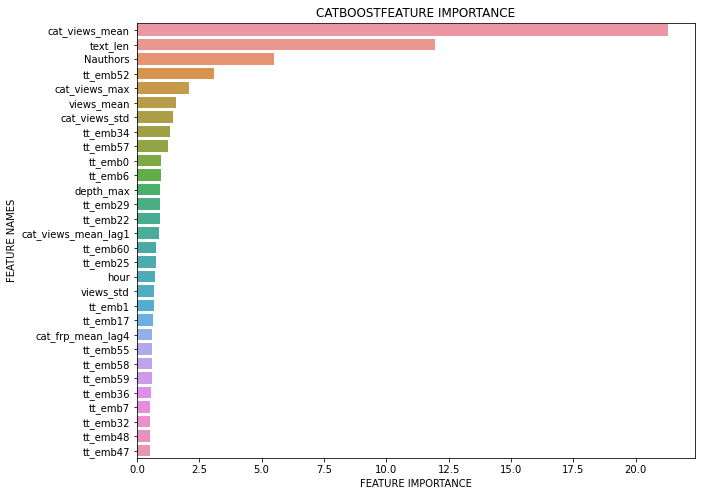

In [22]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_views.get_feature_importance(), train_ds_views.get_feature_names(), 'CATBOOST')

## depth

In [23]:
cb_model_depth = CatBoostRegressor(#iterations=1000,
                                 learning_rate=0.05,
                                 depth=10,
                                 random_seed = CB_RANDOMSEED,
                   n_estimators=100,
                                  )
# Fit model
cb_model_depth.fit(train_ds_depth,
                   eval_set=val_ds_depth, 
                   #plot = True,
                  )

0:	learn: 0.0603010	test: 0.0574305	best: 0.0574305 (0)	total: 537ms	remaining: 53.1s
1:	learn: 0.0583754	test: 0.0556377	best: 0.0556377 (1)	total: 1.12s	remaining: 55s
2:	learn: 0.0563921	test: 0.0536603	best: 0.0536603 (2)	total: 1.67s	remaining: 54.1s
3:	learn: 0.0545400	test: 0.0519702	best: 0.0519702 (3)	total: 2.24s	remaining: 53.7s
4:	learn: 0.0529139	test: 0.0504098	best: 0.0504098 (4)	total: 2.86s	remaining: 54.3s
5:	learn: 0.0513072	test: 0.0488451	best: 0.0488451 (5)	total: 3.42s	remaining: 53.6s
6:	learn: 0.0498265	test: 0.0475095	best: 0.0475095 (6)	total: 3.99s	remaining: 53s
7:	learn: 0.0484773	test: 0.0461885	best: 0.0461885 (7)	total: 4.61s	remaining: 53s
8:	learn: 0.0471000	test: 0.0449116	best: 0.0449116 (8)	total: 5.19s	remaining: 52.4s
9:	learn: 0.0458285	test: 0.0437789	best: 0.0437789 (9)	total: 5.76s	remaining: 51.9s
10:	learn: 0.0446075	test: 0.0426330	best: 0.0426330 (10)	total: 6.33s	remaining: 51.2s
11:	learn: 0.0435406	test: 0.0417520	best: 0.0417520 (11)	

In [24]:
# Get predictions and metrics
preds_train_depth = cb_model_depth.predict(x_train[cat_cols + num_cols])
preds_val_depth   = cb_model_depth.predict(val_ds_depth)

train_score_depth = r2_score(y_train["depth"], preds_train_depth)
val_score_depth   = r2_score(y_val["depth"],   preds_val_depth)

train_score_depth, val_score_depth

(0.8796123117665077, 0.7989995324548504)

In [25]:
x_train.shape

(5584, 287)

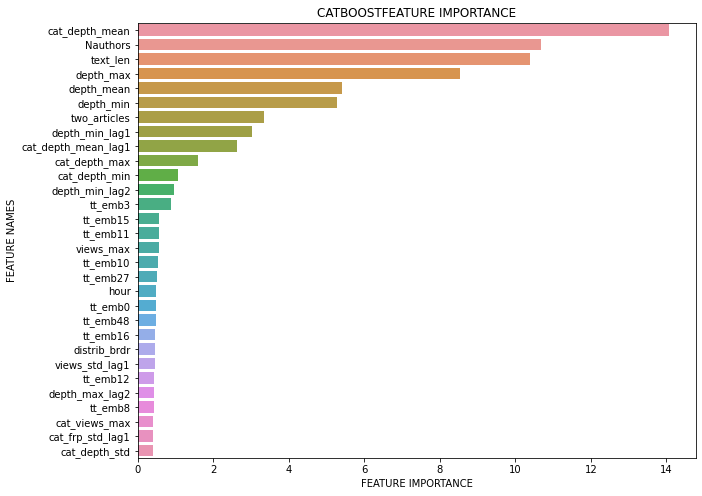

In [26]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_depth.get_feature_importance(), train_ds_depth.get_feature_names(), 'CATBOOST')

## full_reads_percent

In [27]:
#pd.DataFrame(preds_train_depth, columns = ['depth_pred'])
pred_scaler = preprocessing.StandardScaler()
tmp = pred_scaler.fit_transform(preds_train_depth.reshape(-1, 1))
pred_depth_train = pd.DataFrame(tmp, columns = ['depth_pred'])

pred_depth_val   = pd.DataFrame(pred_scaler.transform(preds_val_depth.reshape(-1, 1)), columns = ['depth_pred'])

In [28]:
#train_ds_frp = Pool(x_train[cat_cols + num_cols + ['depth_pred']],
train_ds_frp = Pool(x_train[cat_cols + num_cols],
                      y_train[['full_reads_percent']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols,
                     )

#val_ds_frp   = Pool(x_val[cat_cols + num_cols + ['depth_pred']],
val_ds_frp   = Pool(x_val[cat_cols + num_cols],
                      y_val[['full_reads_percent']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols,
                     )

In [29]:
cb_model_frp = CatBoostRegressor(#iterations=1000,
                                 learning_rate=0.05,
                                 depth=10,
                                 random_seed = CB_RANDOMSEED,
                   n_estimators=100,
                                 #n_estimators=100,
    #num_trees=None,
                                )
# Fit model
cb_model_frp.fit(train_ds_frp,
                   eval_set=val_ds_frp, 
                   #plot = True,
                  )

0:	learn: 9.9261275	test: 10.0263568	best: 10.0263568 (0)	total: 514ms	remaining: 50.9s
1:	learn: 9.7459131	test: 9.8613275	best: 9.8613275 (1)	total: 1.26s	remaining: 1m 1s
2:	learn: 9.5802330	test: 9.7003161	best: 9.7003161 (2)	total: 1.92s	remaining: 1m 1s
3:	learn: 9.4238530	test: 9.5554984	best: 9.5554984 (3)	total: 2.56s	remaining: 1m 1s
4:	learn: 9.2877118	test: 9.4332581	best: 9.4332581 (4)	total: 3.16s	remaining: 1m
5:	learn: 9.1607976	test: 9.3178337	best: 9.3178337 (5)	total: 3.77s	remaining: 59.1s
6:	learn: 9.0395776	test: 9.2063354	best: 9.2063354 (6)	total: 4.37s	remaining: 58.1s
7:	learn: 8.9307640	test: 9.1076540	best: 9.1076540 (7)	total: 4.99s	remaining: 57.4s
8:	learn: 8.8164038	test: 9.0008728	best: 9.0008728 (8)	total: 5.5s	remaining: 55.6s
9:	learn: 8.7174725	test: 8.9205453	best: 8.9205453 (9)	total: 6.07s	remaining: 54.6s
10:	learn: 8.6115360	test: 8.8196864	best: 8.8196864 (10)	total: 6.59s	remaining: 53.3s
11:	learn: 8.5222835	test: 8.7447157	best: 8.7447157 (

In [30]:
# Get predictions and metrics
preds_train_frp = cb_model_frp.predict(x_train[cat_cols + num_cols])
preds_val_frp   = cb_model_frp.predict(val_ds_frp)

train_score_frp = r2_score(y_train["full_reads_percent"], preds_train_frp)
val_score_frp   = r2_score(y_val["full_reads_percent"],   preds_val_frp)

train_score_frp, val_score_frp

(0.6526787438420959, 0.5029928330363905)

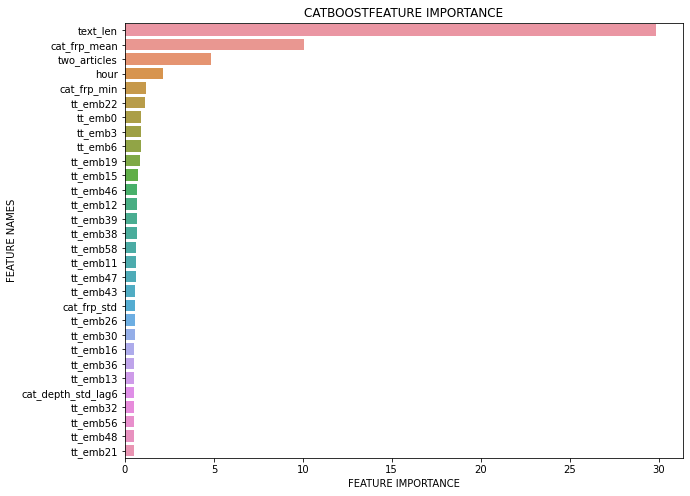

In [31]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_frp.get_feature_importance(), train_ds_frp.get_feature_names(), 'CATBOOST')

In [32]:
score_train = 0.4 * train_score_views + 0.3 * train_score_depth + 0.3 * train_score_frp
score_val  = 0.4 * val_score_views  + 0.3 * val_score_depth  + 0.3 * val_score_frp

score_train, score_val

(0.74770790858208, 0.521943951171824)

## Сохраняем предсказания для ансамблей / стекинга

In [33]:
x_train_pred = x_train[['document_id']]
x_val_pred   = x_val[['document_id']]

print('before ', x_train_pred.shape, preds_train_views.shape, preds_train_depth.shape, preds_train_frp.shape)
print('before ', x_val_pred.shape,   preds_val_views.shape,   preds_val_depth.shape,   preds_val_frp.shape)

# https://github.com/pandas-dev/pandas/issues/25349
x_train_pred = pd.concat([x_train_pred.reset_index(drop=True), 
                          pd.DataFrame(preds_train_views).reset_index(drop = True), 
                          pd.DataFrame(preds_train_depth).reset_index(drop = True), 
                          pd.DataFrame(preds_train_frp).reset_index(drop = True)
                         ], ignore_index = True, axis = 1)
x_val_pred   = pd.concat([x_val_pred.reset_index(drop=True),   
                          pd.DataFrame(preds_val_views).reset_index(drop = True), 
                          pd.DataFrame(preds_val_depth).reset_index(drop = True), 
                          pd.DataFrame(preds_val_frp).reset_index(drop = True)
                         ], ignore_index = True, axis = 1)

x_train_pred.columns = ['document_id', 'views_pred_cb', 'depth_pred_cb', 'frp_pred_cb']
x_val_pred.columns   = ['document_id', 'views_pred_cb', 'depth_pred_cb', 'frp_pred_cb']

print('after ', x_train_pred.shape)
print('after ', x_val_pred.shape)

x_train_pred.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_train_part.csv'), index = False)
x_val_pred.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_val_part.csv'), index = False)

before  (5584, 1) (5584,) (5584,) (5584,)
before  (1397, 1) (1397,) (1397,) (1397,)
after  (5584, 4)
after  (1397, 4)


## save models

In [34]:
#cb_model_views.save_model(os.path.join(DIR_MODELS, f'{NTRY}_pca64_cb_views.cbm'), 
cb_model_views.save_model(os.path.join(DIR_MODELS, f'{NAME}_v.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

cb_model_depth.save_model(os.path.join(DIR_MODELS, f'{NAME}_d.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

cb_model_frp.save_model(os.path.join(DIR_MODELS, f'{NAME}_f.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

## make predict

In [35]:
pred_views = cb_model_views.predict(df_test[cat_cols + num_cols])
pred_depth = cb_model_depth.predict(df_test[cat_cols + num_cols])
pred_frp   = cb_model_frp.predict(  df_test[cat_cols + num_cols])

In [51]:
subm = pd.DataFrame()
subm['document_id'] = df_test.document_id

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [75]:
doc_id_ukr = df_test[df_test.ctr == CTR_UKR].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [69]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

In [71]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,22583.899288,1.206031,47.080588
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,10433.482871,1.063303,29.900982
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,16805.473847,1.060795,29.040686
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,11459.904922,1.062512,35.775333
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,29300.316828,1.137263,31.940685


In [72]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)

In [73]:
df_train.columns

Index(['document_id', 'title', 'publish_date', 'session', 'authors', 'ctr',
       'category', 'tags', 'views', 'depth',
       ...
       'tt_emb54', 'tt_emb55', 'tt_emb56', 'tt_emb57', 'tt_emb58', 'tt_emb59',
       'tt_emb60', 'tt_emb61', 'tt_emb62', 'tt_emb63'],
      dtype='object', length=290)